In [136]:
import json
import pandas as pd
from mgz.model import parse_match, serialize

def prepare_rec(filename, actions_to_remove = []):
    with open(filename, mode='rb') as in_file:
        match = parse_match(in_file)
        jsonFile = json.dumps(serialize(match.actions), indent=2)
    
    df = pd.read_json(jsonFile)
    
    df['player'] = df['player'].apply(lambda x: x.get('number') if isinstance(x, dict) else x)
        
    player_mapping = {i+1: str(name) for i, name in enumerate(match.players)}
    df['player'] = df['player'].replace(player_mapping)
             
    columns = ['timestamp', 'player', 'type']
        
    filtered_df = df[columns][~df['type'].isin(actions_to_remove + ['GAME','DE_TRANSFORM'])]
    
    filtered_df['datetime'] = pd.to_datetime(df['timestamp'])
    start_time = filtered_df['datetime'].min()
    filtered_df['relative_minute'] = (filtered_df['datetime'] - start_time).dt.total_seconds() // 60   
    aggregated = filtered_df.groupby(['player', 'relative_minute', 'type']).size().reset_index(name='count')
    return aggregated

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns

import colorsys
    
def generate_colors(n):
    """Generate n distinct colors using HSL and convert to RGB."""
    return [colorsys.hls_to_rgb(i/n, 0.5, 0.8) for i in range(n)]

def plot_rec(df_rec): 
    # Pivot the aggregated DataFrame to have action types as columns
    pivoted = df_rec.pivot_table(index=['player', 'relative_minute'], columns='type', values='count', fill_value=0).reset_index()
    
    players = df_rec['player'].unique()
    
    # Set up the visual aesthetics for Seaborn
    sns.set(style="whitegrid")
    
    # Define a color palette
    unique_action_types = df_rec['type'].unique()
    palette = generate_colors(len(unique_action_types))
    color_mapping = dict(zip(unique_action_types, palette))
    stacking_order = sorted(unique_action_types)
    
    def get_stacking_order(df):
        return df[stacking_order].sum().sort_values(ascending=False).index.tolist()
    
    # Create a figure and axis objects
    fig, axes = plt.subplots(nrows=len(players), figsize=(20, 6*len(players)))  # Adjust the width for additional legend space
    
    for ax, player in zip(axes, players):
        player_data = pivoted[pivoted['player'] == player]
        
        # Compute the average actions per minute for this player
        total_actions = player_data[stacking_order].sum().sum()
        total_minutes = len(player_data)
        avg_actions_per_minute = total_actions / total_minutes
    
        # Determine the general order for stacking for this player
        player_order = get_stacking_order(player_data)
    
        # Iterate over the minutes and plot bars based on the order determined above
        bottom = None
        for action_type in player_order:
            ax.bar(player_data['relative_minute'], player_data[action_type], label=action_type, bottom=bottom, color=color_mapping[action_type])
            bottom = player_data[action_type] if bottom is None else bottom + player_data[action_type]
    
        ax.set_title(f"Actions for {player}")
        ax.set_ylabel("Count of Actions")
        ax.set_xlabel("Relative Minute")
        
        # Annotate the chart with the average actions per minute
        ax.text(0.02, 0.85, f'Avg actions/min: {avg_actions_per_minute:.2f}', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.7))
    
    
    
        # Set the legend for the last axis outside of the plot on the right side
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.show()



**scout rush game with lemonbee on lombardia**

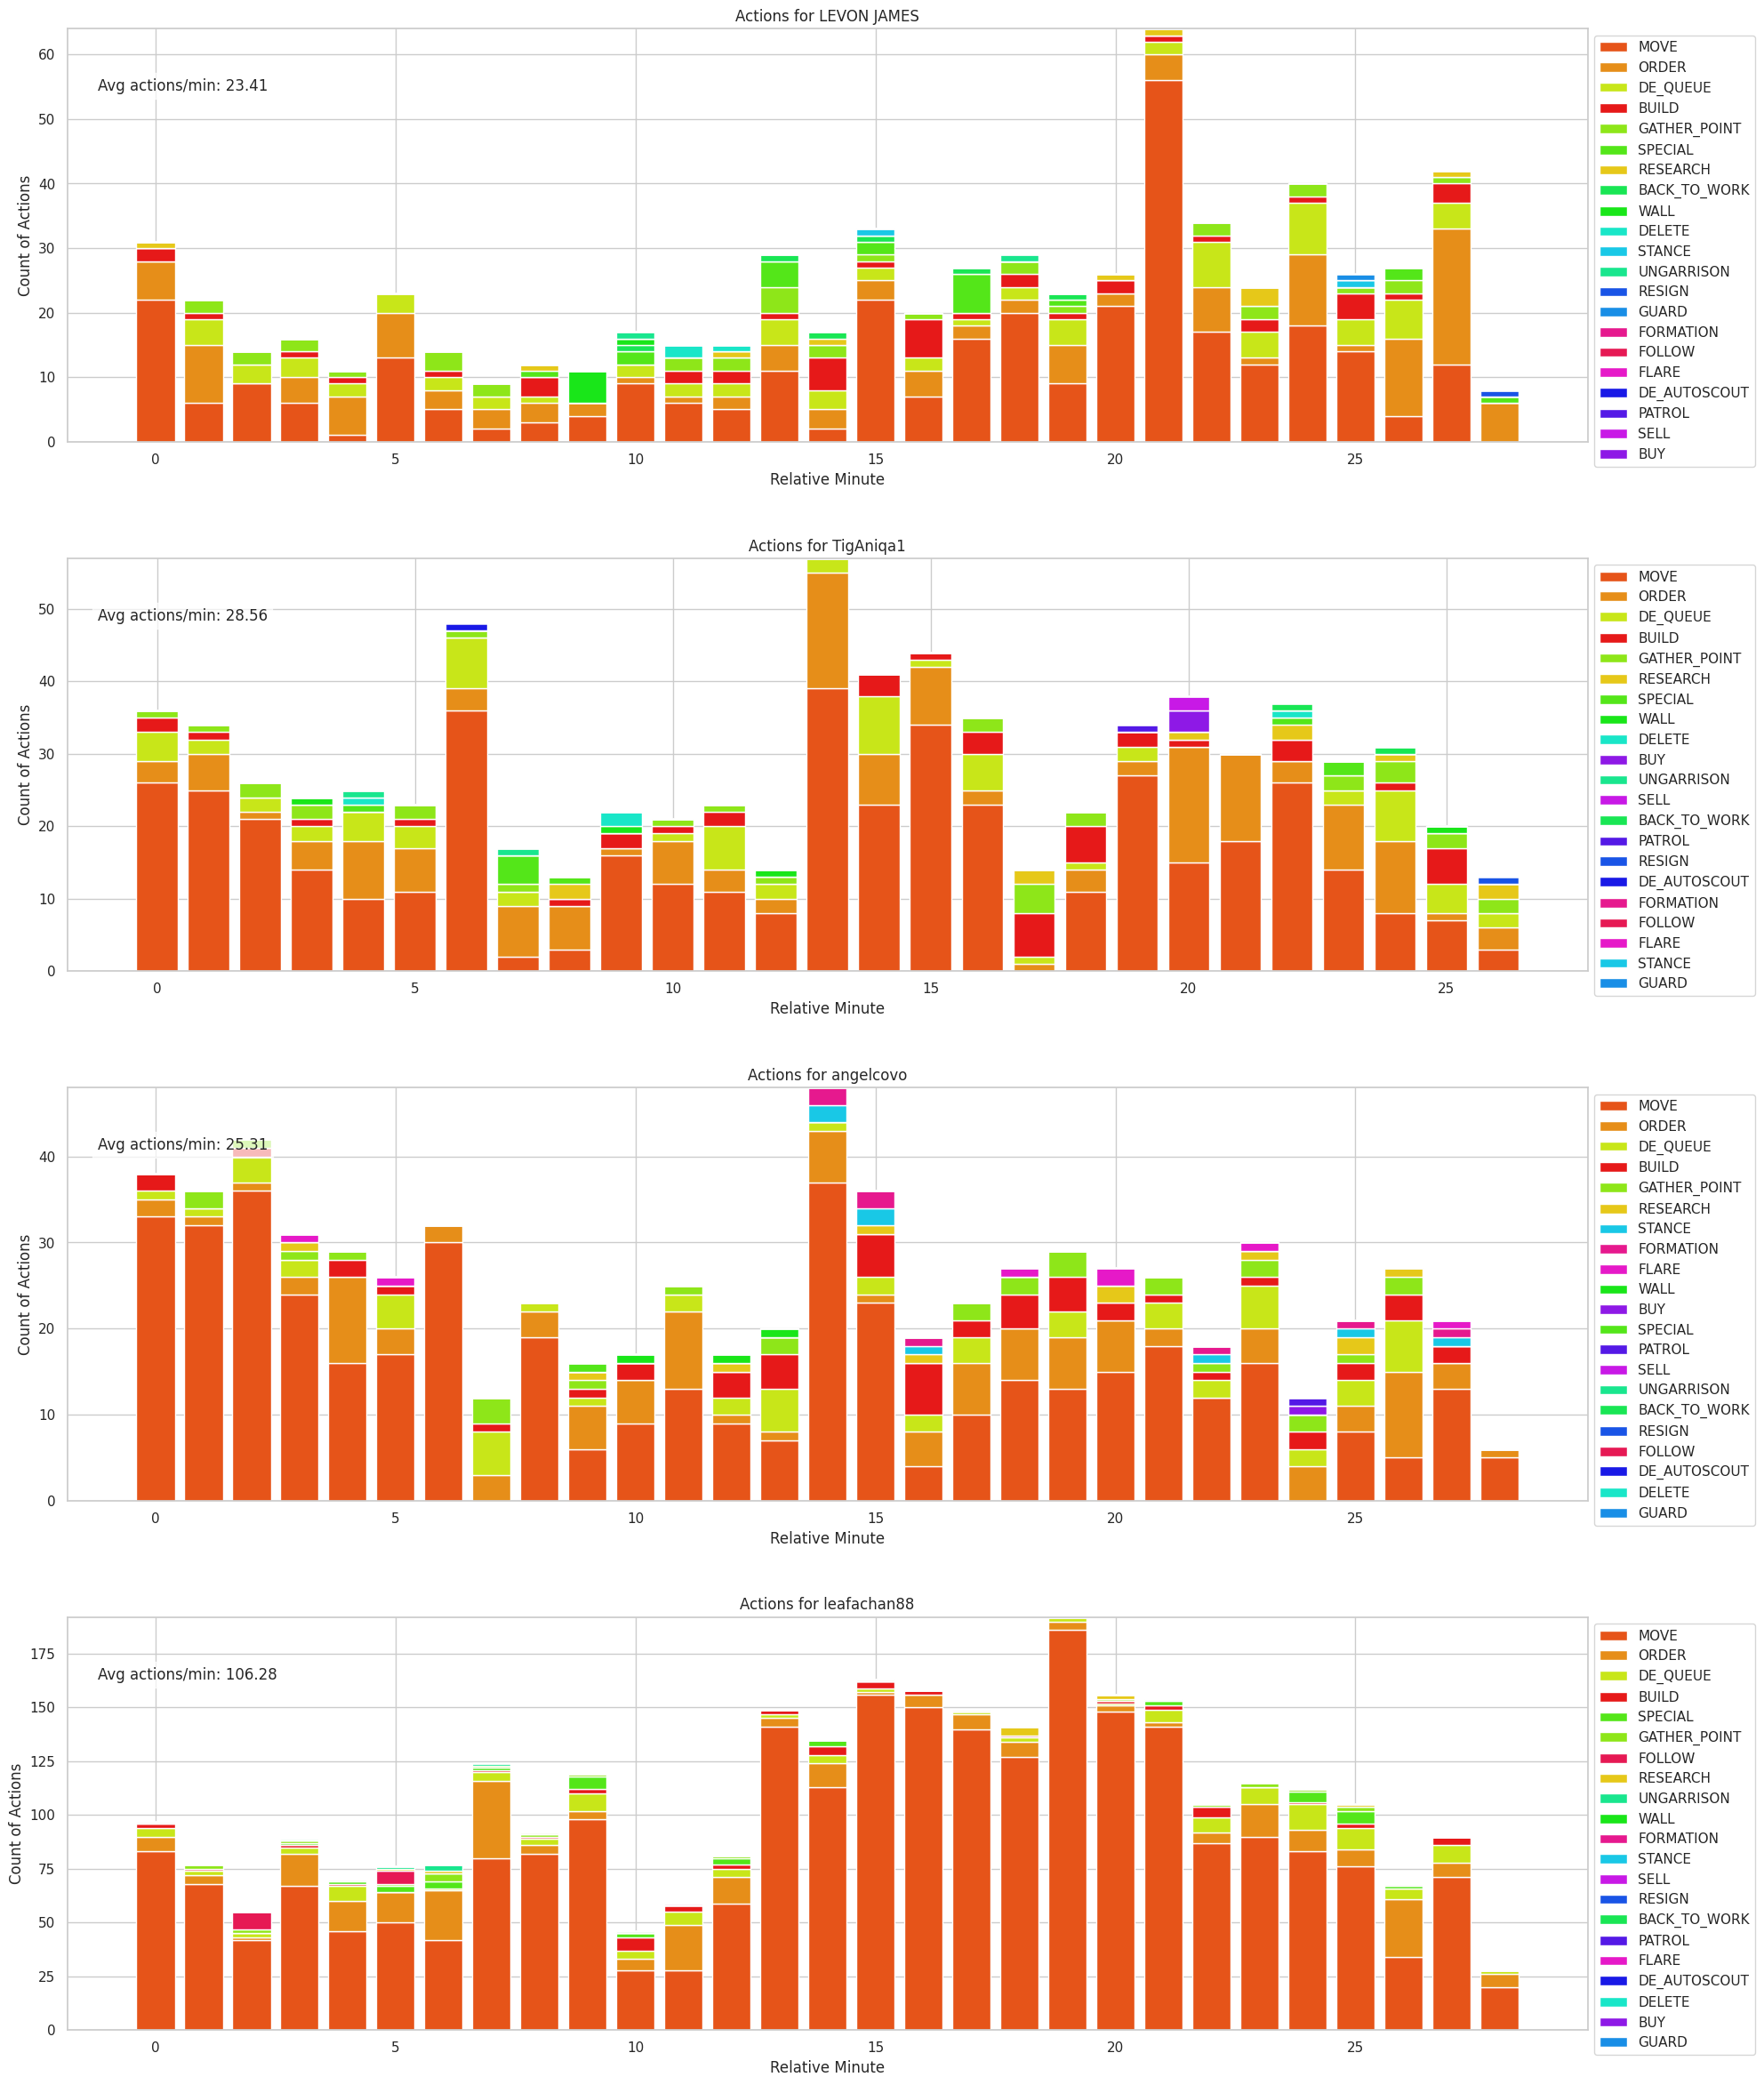

In [138]:
plot_rec(prepare_rec('./replay.aoe2record'))

**latest 3v3 (animatect, tornasol, peyo)**

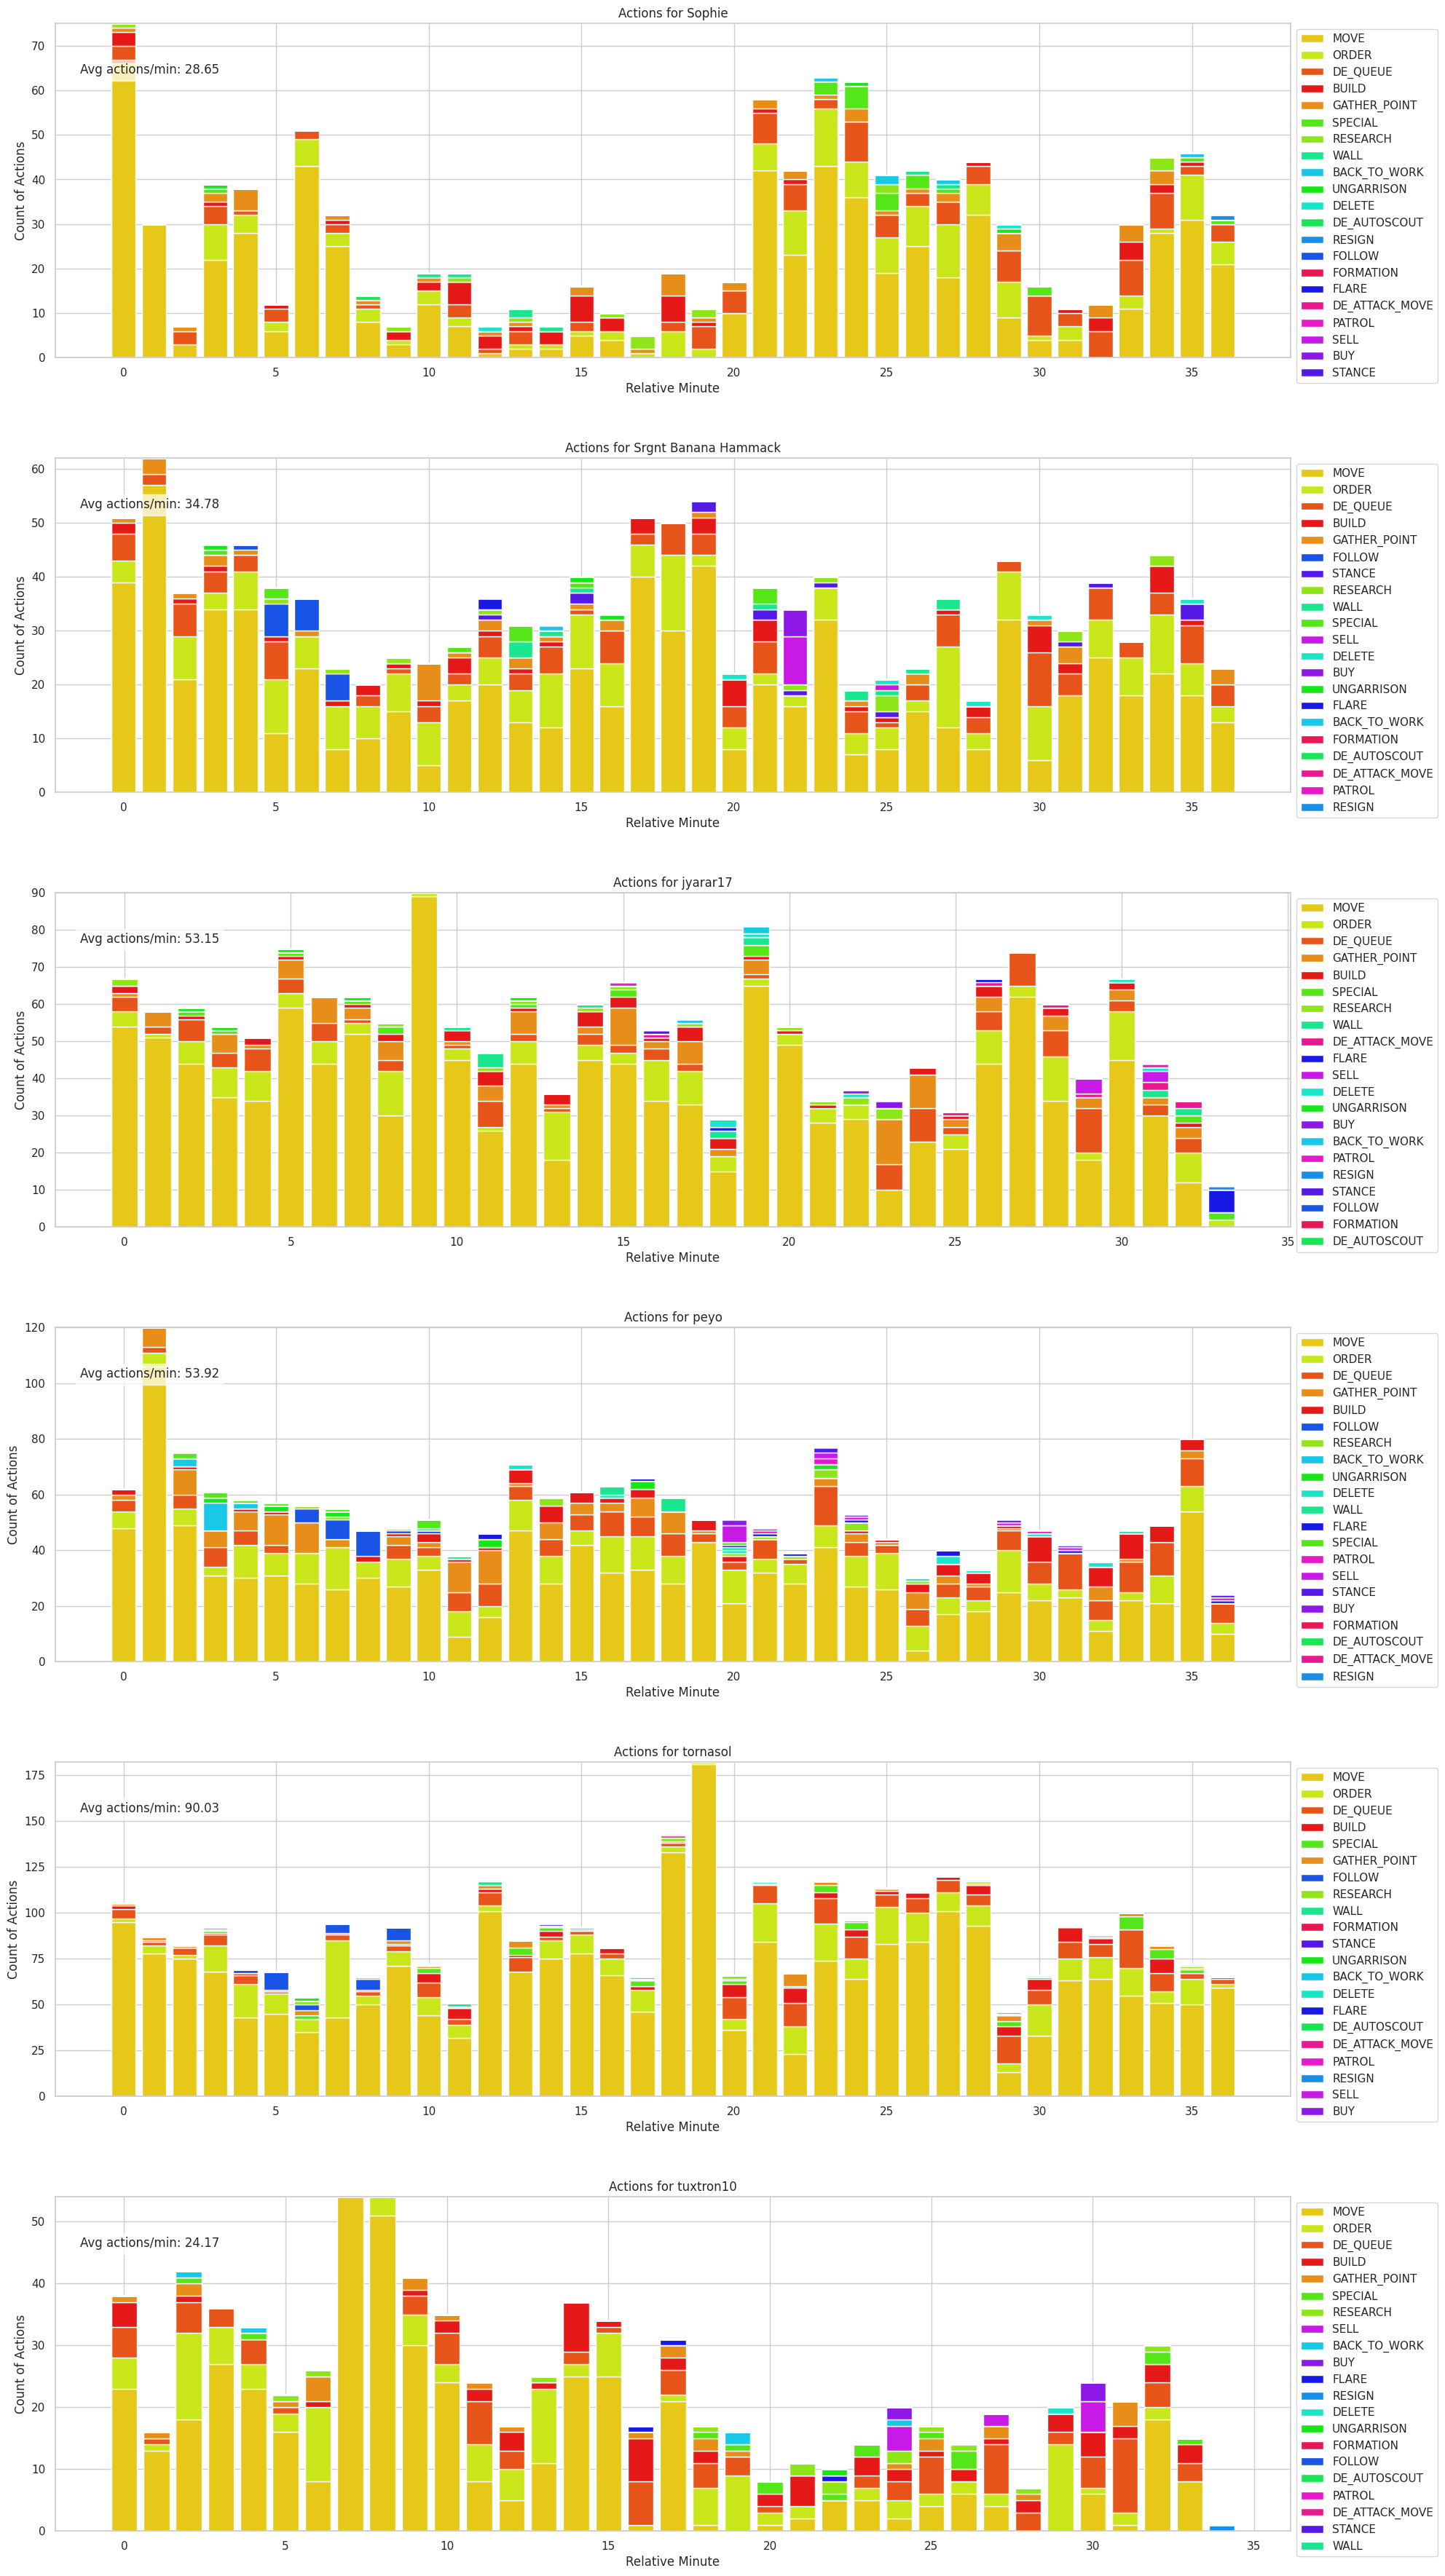

In [142]:
plot_rec(prepare_rec('./replay2.aoe2record'))

**latest 3v3 removing MOVE action**

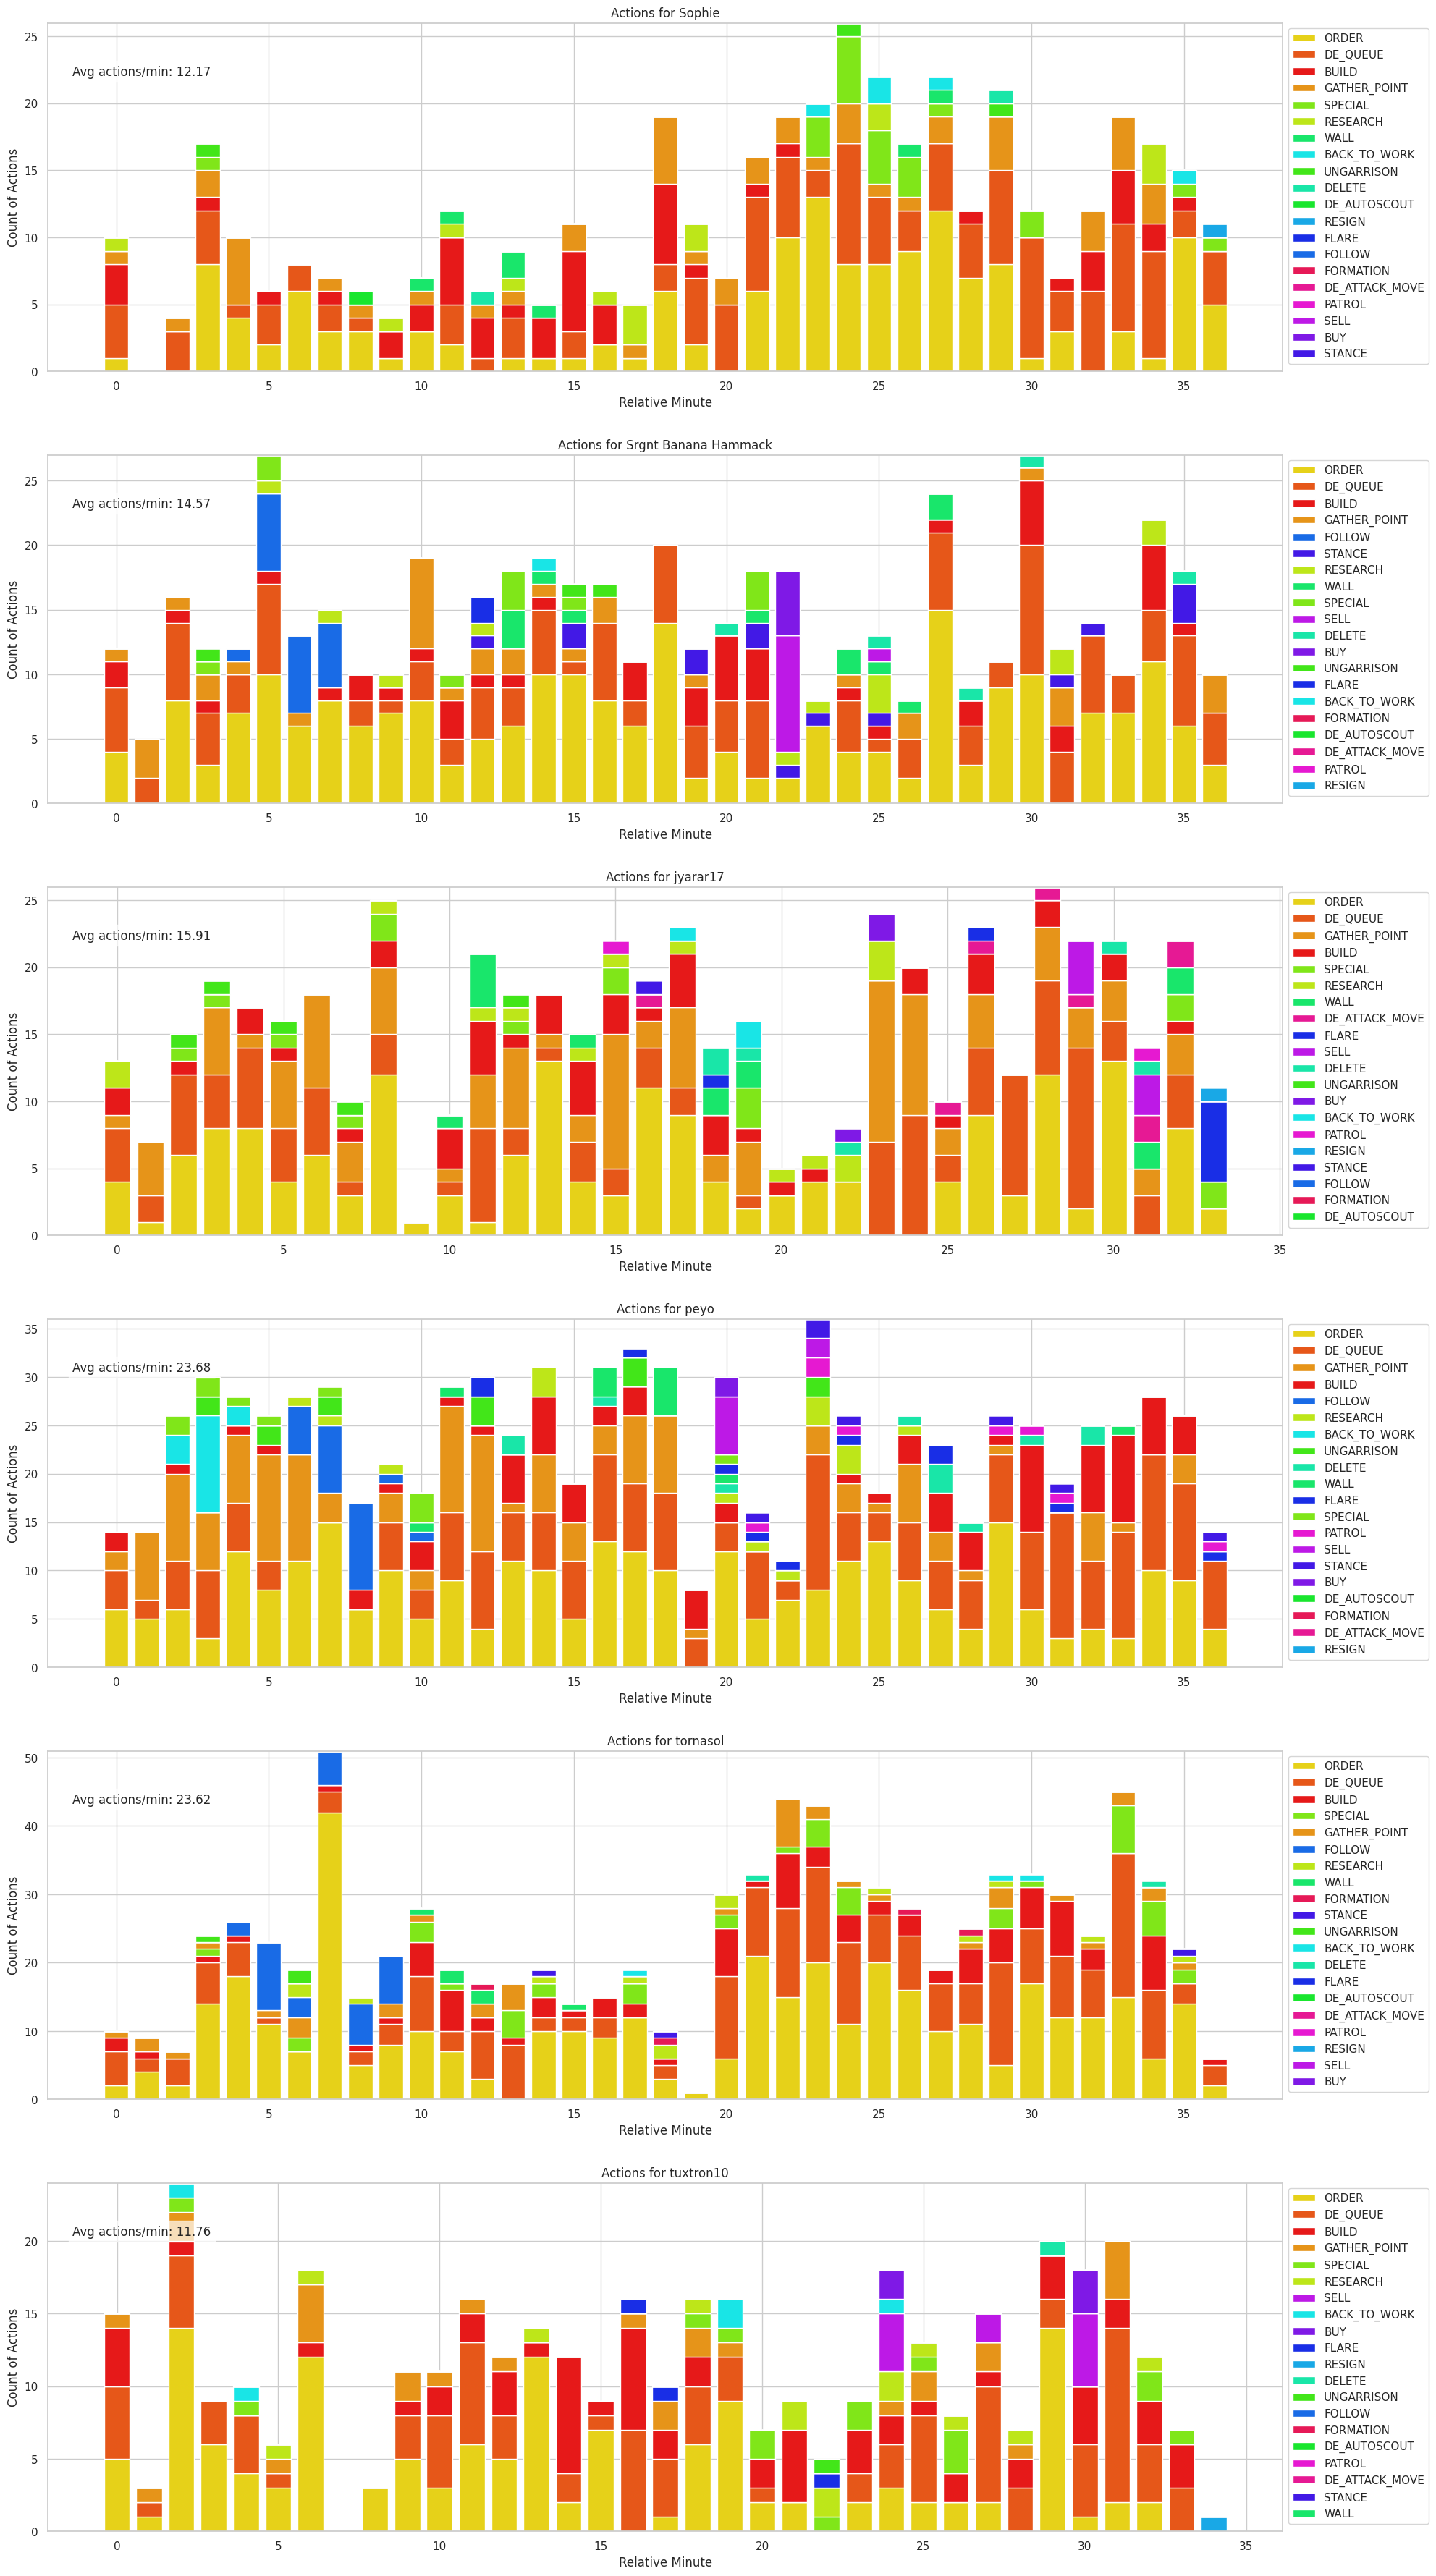

In [141]:
plot_rec(prepare_rec('./replay2.aoe2record',['MOVE']))

**random pro ladder game**

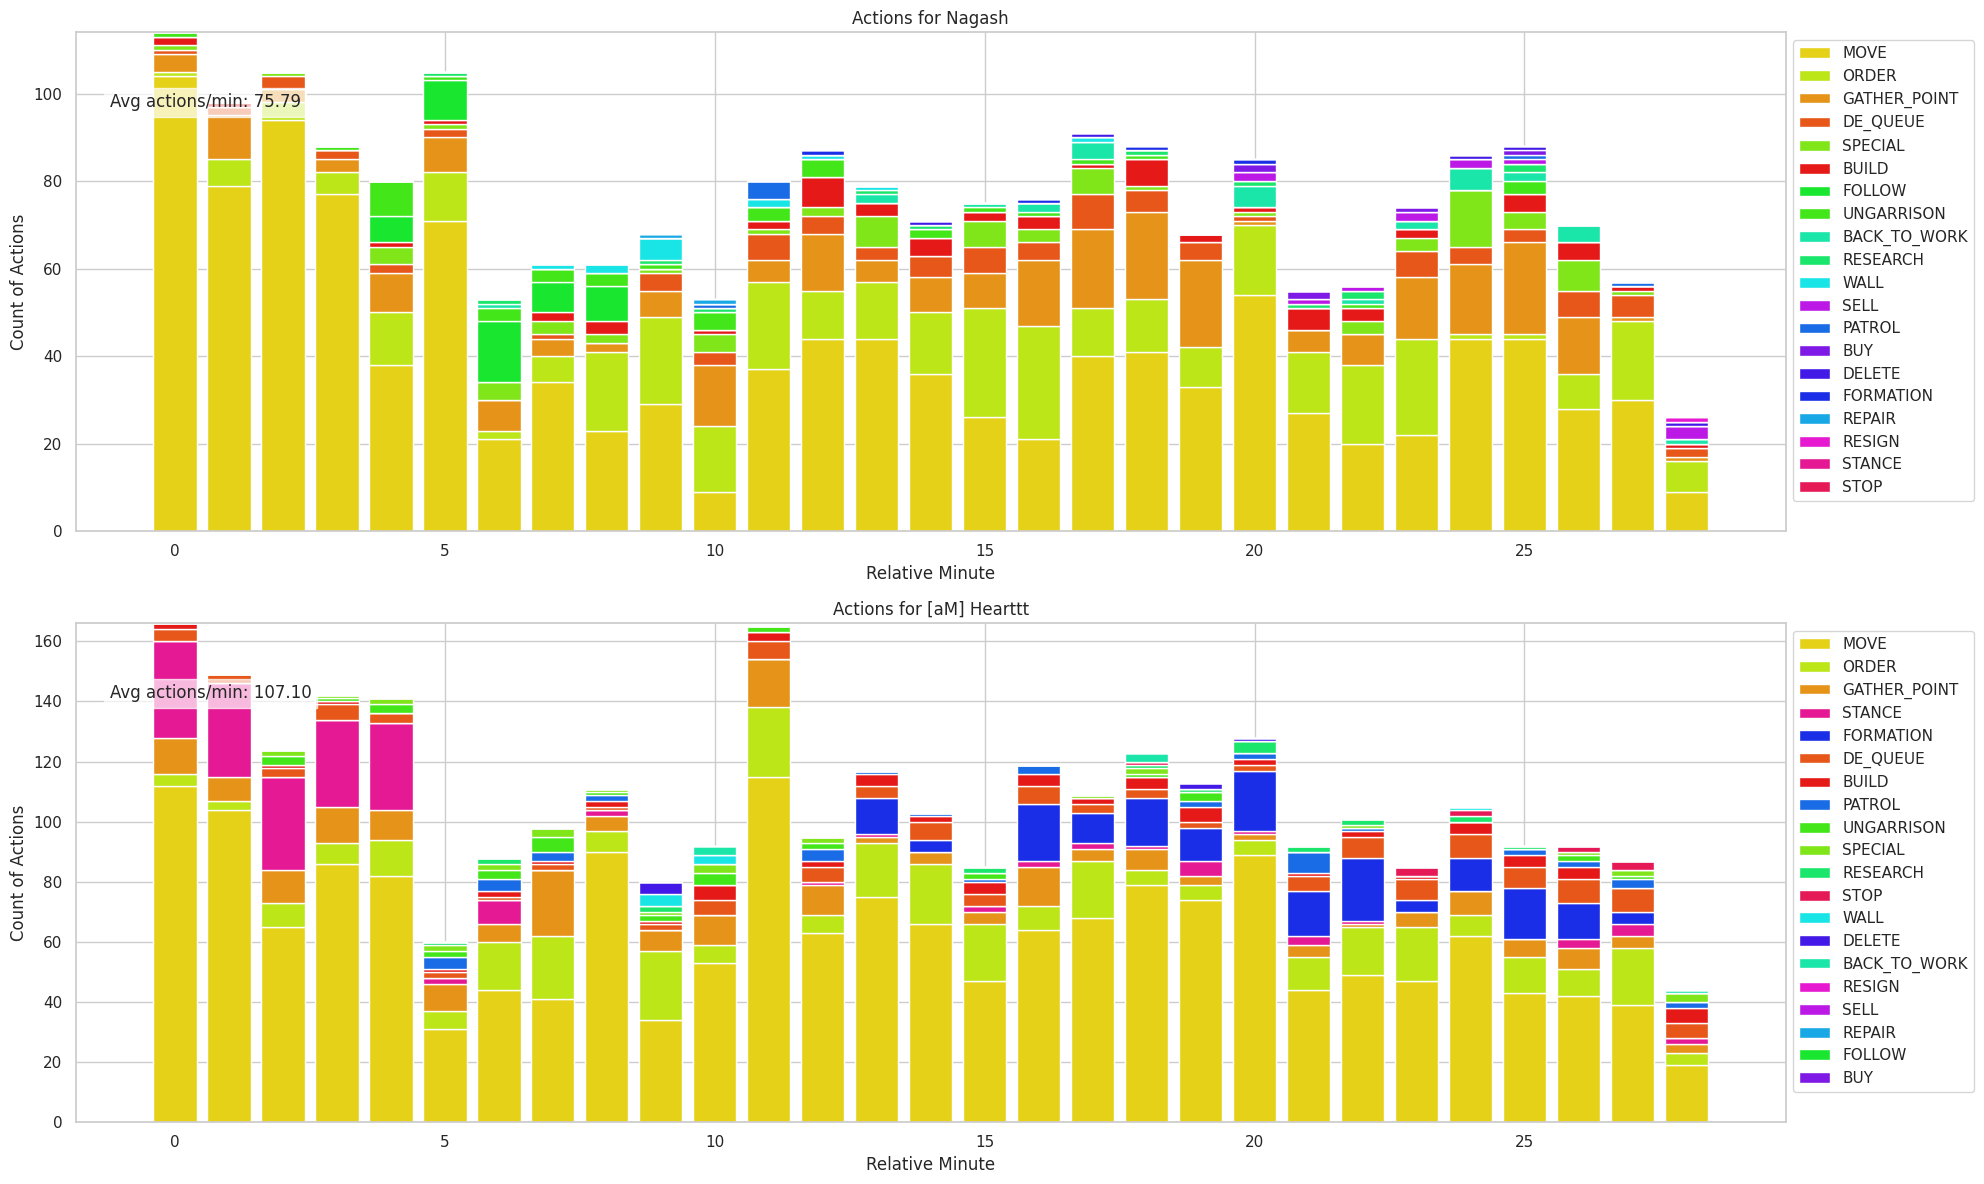

In [127]:
plot_rec(prepare_rec('./hearttt.aoe2record'))